# Capstone 3 - Exploratory Data Analysis

### Table of contents
* [Introduction](#intro)
    * [Guiding questions](#guiding-questions)
    * [Import relevant packages](#import)
    * [Retrieve variables](#variables)
    * [Data validation](#validation)
* [Examining numerical variable distributions](#variable-distributions)

## Introduction <a name="intro"></a>

Despite ample evidence of causing mental and physical harm, the effects of environmental noise on educational outcomes is not well documented. This project aims to understand how environmental noise affects educational outcomes of elementary, middle, and high schoolers in New York City between the 2016-2017 and 2018-2019 school years.

This notebook for Exploratory Data Analysis picks up where we left off in section 1 - Cleaning & Wrangling.

### Guiding questions <a name="guiding-questions"></a>

Guiding questions as we complete our Exploratory Data Analysis include:
- Does increased noise exposure correlate with decreased academic performance?
- Can we predict a school's academic performance based on its noise exposure profile?
- How much variance in student achievement can be explained by environmental noise?
- Can we identify schools that are most vulnerable to noise impacts?
- Can we predict which schools will exceed/fall below performance targets based on noise exposure?
- Do certain types of noise (e.g., construction, traffic) have different impacts?
- Are there temporal patterns in noise impact (time of day, day of week, seasonal)?

### Import relevant packages <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Retrieve variables <a name="variables"></a>
Let's retrieve the variables we saved in our data cleaning & wrangling phase.

In [2]:
# Retrieve original noise_data dataframe
%store -r noise_data

# Retrieve GeoPandas dataframes
%store -r districts_gdf 
%store -r schoolpoints_gdf

# Retrieve schools covered by sensor range
%store -r coverage_matrix

# Retrieve school demographic information
%store -r coverage_combined_summary_df
%store -r non_coverage_combined_summary_df

# Retrieve lower grades achievement information
%store -r coverage_lg_achievement_df
%store -r non_coverage_lg_achievement_df

# Retrieve high school achievement information
%store -r coverage_hs_achievement_df
%store -r non_coverage_hs_achievement_df

# Retrieve combined achievement data
%store -r coverage_combined_achievement_df
%store -r non_coverage_combined_achievement_df

# Retrieve merged dataset with all metrics
%store -r merged_coverage_df

# Retrieve school lists
%store -r elem_middle_schools
%store -r high_schools

In [3]:
final_df = merged_coverage_df

---
## Data Quality Analysis

In [4]:
def validate_loaded_data(dfs_dict):
    """
    Validate loaded dataframes for expected properties and structure
    """
    print("Running Data Validation Checks...")
    
    # Expected columns for each dataframe
    expected_columns = {
        'noise_data': ['sensor_id', 'borough', 'latitude', 'longitude', 'date', 'is_school_day'],
        'coverage_matrix': ['DBN', 'num_sensors', 'num_recordings', 'min_distance_km', 'max_distance_km'],
        'coverage_combined_summary_df': ['DBN', 'school_name', 'academic_year'],
        'non_coverage_combined_summary_df': ['DBN', 'school_name', 'academic_year'],
        'coverage_lg_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'non_coverage_lg_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'coverage_hs_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'non_coverage_hs_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'coverage_combined_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'non_coverage_combined_achievement_df': ['DBN', 'school_name', 'academic_year'],
        'merged_coverage_df': ['DBN', 'school_name', 'academic_year'],
        'elem_middle_schools': ['DBN', 'school_name', 'school_type'],
        'high_schools': ['DBN', 'school_name', 'school_type']
    }
    
    # Expected number of rows (approximate)
    expected_rows = {
        'elem_middle_schools': (400, 2000),  # (min, max)
        'high_schools': (400, 2000),
        'coverage_matrix': (100, 500)
    }
    
    validation_results = {}
    
    for df_name, df in dfs_dict.items():
        print(f"\n{'='*50}")
        print(f"Validating {df_name}...")
        results = {}
        
        # Basic checks
        results['row_count'] = len(df)
        results['column_count'] = len(df.columns)
        results['null_counts'] = df.isnull().sum().to_dict()
        
        # Check for expected columns
        if df_name in expected_columns:
            missing_cols = set(expected_columns[df_name]) - set(df.columns)
            results['missing_columns'] = list(missing_cols)
            if missing_cols:
                print(f"WARNING: Missing expected columns in {df_name}: {missing_cols}")
        
        # Check row counts
        if df_name in expected_rows:
            min_rows, max_rows = expected_rows[df_name]
            if not (min_rows <= len(df) <= max_rows):
                print(f"WARNING: Unexpected number of rows in {df_name}. "
                      f"Expected between {min_rows} and {max_rows}, got {len(df)}")
        
        # Check for duplicate DBNs in reference dataframes
        if df_name in ['elem_middle_schools', 'high_schools']:
            duplicates = df['DBN'].duplicated().sum()
            results['duplicate_dbns'] = duplicates
            if duplicates > 0:
                print(f"WARNING: Found {duplicates} duplicate DBNs in {df_name}")
        
        # Check academic year format where applicable
        if 'academic_year' in df.columns:
            year_format = df['academic_year'].astype(str).str.match(r'\d{4}-\d{4}').all()
            results['valid_year_format'] = year_format
            if not year_format:
                print(f"WARNING: Invalid academic year format in {df_name}")
        
        # Check data types
        results['dtypes'] = df.dtypes.to_dict()
        
        # GeoPandas specific checks
        if df_name in ['districts_gdf', 'schoolpoints_gdf']:
            if not hasattr(df, 'crs'):
                print(f"WARNING: {df_name} does not have CRS information")
        
        # Coverage checks
        if 'coverage' in df_name:
            print("\nCoverage Information:")
            print(f"Unique schools: {df['DBN'].nunique()}")
            if 'academic_year' in df.columns:
                print(f"Years covered: {sorted(df['academic_year'].unique())}")
        
        # Store results
        validation_results[df_name] = results
        
        # Print summary
        print(f"\nSummary for {df_name}:")
        print(f"- Rows: {results['row_count']}")
        print(f"- Columns: {results['column_count']}")
        print(f"- Columns with null values: {sum(1 for v in results['null_counts'].values() if v > 0)}")
    
    return validation_results

# Create dictionary of dataframes
dfs = {
    'noise_data': noise_data,
    'districts_gdf': districts_gdf,
    'schoolpoints_gdf': schoolpoints_gdf,
    'coverage_matrix': coverage_matrix,
    'coverage_combined_summary_df': coverage_combined_summary_df,
    'non_coverage_combined_summary_df': non_coverage_combined_summary_df,
    'coverage_lg_achievement_df': coverage_lg_achievement_df,
    'non_coverage_lg_achievement_df': non_coverage_lg_achievement_df,
    'coverage_hs_achievement_df': coverage_hs_achievement_df,
    'non_coverage_hs_achievement_df': non_coverage_hs_achievement_df,
    'coverage_combined_achievement_df': coverage_combined_achievement_df,
    'non_coverage_combined_achievement_df': non_coverage_combined_achievement_df,
    'merged_coverage_df': merged_coverage_df,
    'elem_middle_schools': elem_middle_schools,
    'high_schools': high_schools
}

# Run validation
validation_results = validate_loaded_data(dfs)

Running Data Validation Checks...

Validating noise_data...

Summary for noise_data:
- Rows: 17958
- Columns: 39
- Columns with null values: 0

Validating districts_gdf...

Summary for districts_gdf:
- Rows: 33
- Columns: 4
- Columns with null values: 0

Validating schoolpoints_gdf...

Summary for schoolpoints_gdf:
- Rows: 1950
- Columns: 8
- Columns with null values: 0

Validating coverage_matrix...

Coverage Information:
Unique schools: 72

Summary for coverage_matrix:
- Rows: 72
- Columns: 57
- Columns with null values: 0

Validating coverage_combined_summary_df...

Coverage Information:
Unique schools: 1663
Years covered: ['2016-2017', '2017-2018', '2018-2019']

Summary for coverage_combined_summary_df:
- Rows: 5304
- Columns: 14
- Columns with null values: 3

Validating non_coverage_combined_summary_df...

Coverage Information:
Unique schools: 1663
Years covered: ['2016-2017', '2017-2018', '2018-2019']

Summary for non_coverage_combined_summary_df:
- Rows: 5304
- Columns: 14
- Col

In [5]:
def check_dataframe_relationships(dfs):
    """Check if schools in dataframes are valid (exist in reference lists)"""
    print("\nChecking school validity in dataframes...")
    
    # Get reference sets of valid school DBNs
    valid_lg_schools = set(dfs['elem_middle_schools']['DBN'])
    valid_hs_schools = set(dfs['high_schools']['DBN'])
    all_valid_schools = valid_lg_schools.union(valid_hs_schools)
    
    # Check each relevant dataframe
    for df_name, df in dfs.items():
        if 'DBN' in df.columns and df_name not in ['elem_middle_schools', 'high_schools']:
            df_schools = set(df['DBN'])
            invalid_schools = df_schools - all_valid_schools
            
            print(f"\nChecking {df_name}:")
            print(f"Total schools in dataframe: {len(df_schools)}")
            
            if invalid_schools:
                print(f"WARNING: Found {len(invalid_schools)} invalid school DBNs:")
                print(sorted(invalid_schools))
            else:
                print("All schools are valid!")
            
            # Additional checks for achievement dataframes
            if 'lg_achievement' in df_name:
                non_lg_schools = df_schools - valid_lg_schools
                if non_lg_schools:
                    print(f"WARNING: Found {len(non_lg_schools)} high schools in lower grades achievement data:")
                    print(sorted(non_lg_schools))
            
            elif 'hs_achievement' in df_name:
                non_hs_schools = df_schools - valid_hs_schools
                if non_hs_schools:
                    print(f"WARNING: Found {len(non_hs_schools)} lower grades schools in high school achievement data:")
                    print(sorted(non_hs_schools))

# Run the check
check_dataframe_relationships(dfs)


Checking school validity in dataframes...

Checking coverage_matrix:
Total schools in dataframe: 72
['01M458', '01M650', '02M340', '02M394', '02M560', '02M575', '02M586', '13K482', '15K423', '15K456', '15K698', '75K369', '75M169', '75M226', '75M721', '75M751', '79M984', '84K937']

Checking coverage_combined_summary_df:
Total schools in dataframe: 1663
All schools are valid!

Checking non_coverage_combined_summary_df:
Total schools in dataframe: 1663
All schools are valid!

Checking coverage_lg_achievement_df:
Total schools in dataframe: 29
All schools are valid!

Checking non_coverage_lg_achievement_df:
Total schools in dataframe: 1267
All schools are valid!

Checking coverage_hs_achievement_df:
Total schools in dataframe: 30
All schools are valid!

Checking non_coverage_hs_achievement_df:
Total schools in dataframe: 496
All schools are valid!

Checking coverage_combined_achievement_df:
Total schools in dataframe: 54
All schools are valid!

Checking non_coverage_combined_achievement_d

In [12]:
coverage_matrix[coverage_matrix['DBN']=='01M458']

,DBN,num_sensors,num_recordings,min_distance_km,max_distance_km,sensor_0,sensor_1,sensor_10,sensor_11,sensor_12,...,sensor_52,sensor_53,sensor_55,sensor_56,sensor_57,sensor_6,sensor_61,sensor_7,sensor_8,sensor_9
school_name,,,,,,,,,,,,,,,,,,,,,
Forsyth Satellite Academy,01M458,2,964,1.952613,1.967687,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
elem_middle_schools[elem_middle_schools['school_name']=='Forsyth Satellite Academy']

,DBN,school_name,school_type,coverage


Additionally, as part of our data validation, let's double check the data types in `final_df` to see whether we need to change any data types. (These changes should have been made in our cleaning & wrangling phase, but just to be sure, we will double check.)

In [16]:
final_df.dtypes

DBN                               object
school_name                       object
enrollment                         int64
ell_pct                          float64
disability_pct                   float64
self_contained_pct               float64
asian_pct                        float64
black_pct                        float64
hispanic_pct                     float64
white_pct                        float64
student_attendance_rate          float64
chronic_absence_pct              float64
teacher_attendance_rate          float64
academic_year                     object
school_type                       object
achievement_rating                object
achievement_score                float64
ela_proficient_pct               float64
ela_avg_proficiency              float64
ela_lowest_third_proficiency     float64
math_proficient_pct              float64
math_avg_proficiency             float64
math_lowest_third_proficiency    float64
attendance_90_plus_pct           float64
ela_proficient_n

### Examining Numerical Variable Distributions <a name="variable-distributions"></a>

Let's look at demographic data.

Analyzing these numerical columns:
['enrollment', 'ell_pct', 'disability_pct', 'self_contained_pct', 'asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'student_attendance_rate', 'chronic_absence_pct', 'teacher_attendance_rate', 'achievement_score', 'ela_proficient_pct', 'ela_avg_proficiency', 'ela_lowest_third_proficiency', 'math_proficient_pct', 'math_avg_proficiency', 'math_lowest_third_proficiency', 'attendance_90_plus_pct', 'ela_proficient_n', 'math_proficient_n', 'ela_lowest_third_n', 'math_lowest_third_n', 'grad_rate_4yr', 'grad_rate_6yr', 'regents_english', 'regents_algebra', 'regents_living_env', 'regents_global', 'regents_us_history', 'college_prep_index', 'college_ready_4yr', 'college_ready_6yr', 'postsec_enroll_6mo', 'postsec_enroll_18mo', 'credits_yr1', 'credits_yr2', 'credits_yr3', 'grad_rate_n', 'regents_english_n', 'college_ready_n', 'num_sensors', 'num_recordings', 'min_distance_km', 'max_distance_km']

Analysis of enrollment

Basic Statistics:
count     207.000000


Analysis of math_lowest_third_proficiency

Basic Statistics:
count    93.000000
mean      2.513226
std       0.541395
min       1.740000
25%       2.040000
50%       2.400000
75%       2.950000
max       3.920000
Name: math_lowest_third_proficiency, dtype: float64

Skewness: 0.48
Kurtosis: -0.66

Analysis of attendance_90_plus_pct

Basic Statistics:
count    202.000000
mean       0.768525
std        0.160992
min        0.420000
25%        0.655250
50%        0.815000
75%        0.921000
max        0.990000
Name: attendance_90_plus_pct, dtype: float64

Skewness: -0.52
Kurtosis: -0.81

Analysis of ela_proficient_n

Basic Statistics:
count    102.000000
mean     249.852941
std      164.379385
min       25.000000
25%      147.500000
50%      261.000000
75%      311.000000
max      935.000000
Name: ela_proficient_n, dtype: float64

Skewness: 1.73
Kurtosis: 5.28

Note: Distribution is significantly skewed
Note: Distribution has heavy tails

Outliers detected: 3 (1.4%)
Outlier range: 877.00 


Analysis of min_distance_km

Basic Statistics:
count    207.000000
mean       1.234836
std        0.561234
min        0.339470
25%        0.785748
50%        1.310983
75%        1.755361
max        1.997274
Name: min_distance_km, dtype: float64

Skewness: -0.20
Kurtosis: -1.36

Analysis of max_distance_km

Basic Statistics:
count    207.000000
mean       1.556242
std        0.442187
min        0.453611
25%        1.332921
50%        1.773424
75%        1.927432
max        1.997274
Name: max_distance_km, dtype: float64

Skewness: -0.95
Kurtosis: -0.29


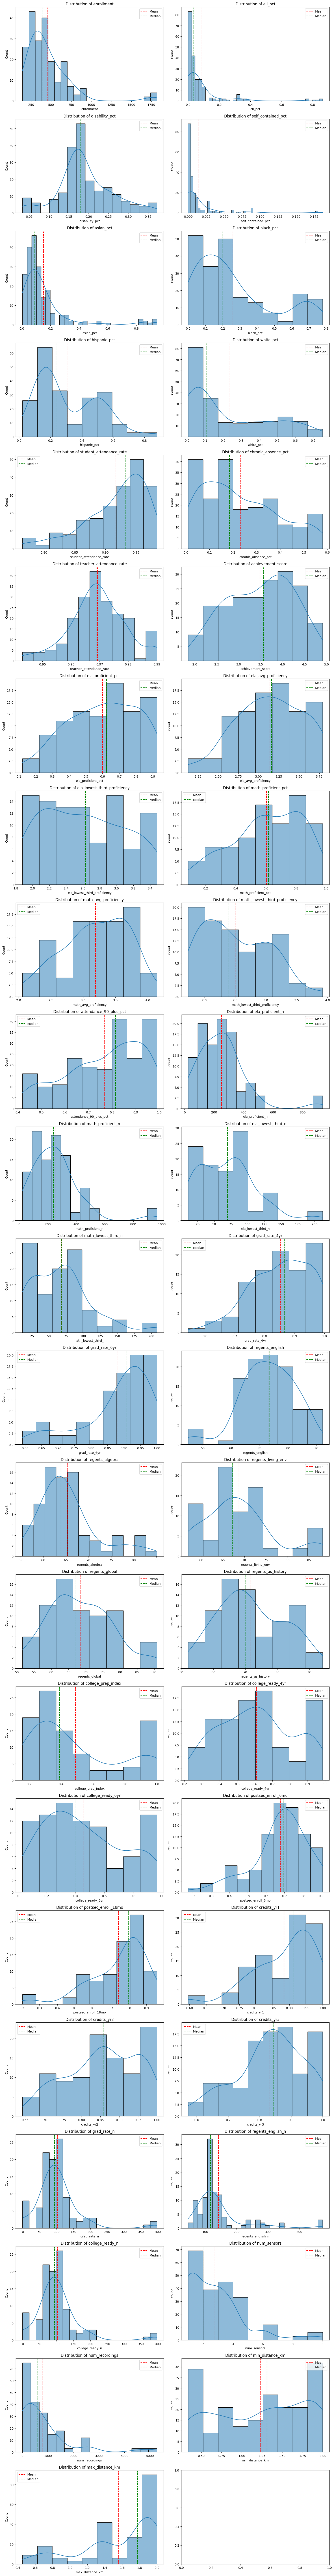


Summary Table of Key Metrics:
                                     Mean      Median      Std Dev  Skewness  \
enrollment                     456.512077  386.000000   289.143745  2.770617   
ell_pct                          0.082599    0.032000     0.151502  3.639411   
disability_pct                   0.190797    0.179000     0.068061  0.271330   
self_contained_pct               0.014725    0.004000     0.028546  3.672489   
asian_pct                        0.152430    0.091000     0.183299  2.989664   
black_pct                        0.259836    0.201000     0.222518  0.973974   
hispanic_pct                     0.312000    0.236000     0.195999  0.671230   
white_pct                        0.233986    0.107000     0.225865  0.776905   
student_attendance_rate          0.917485    0.933500     0.050517 -1.080660   
chronic_absence_pct              0.231475    0.185000     0.160992  0.524431   
teacher_attendance_rate          0.969273    0.969000     0.009740 -0.120908   
achieveme

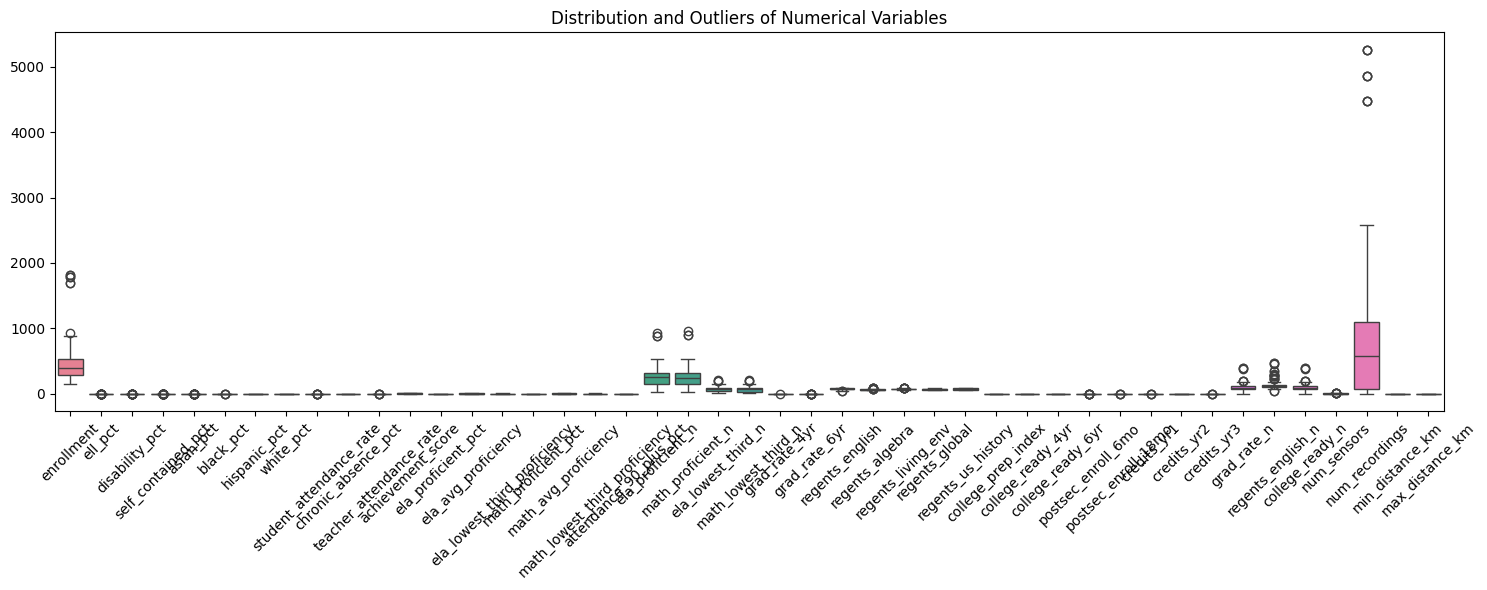

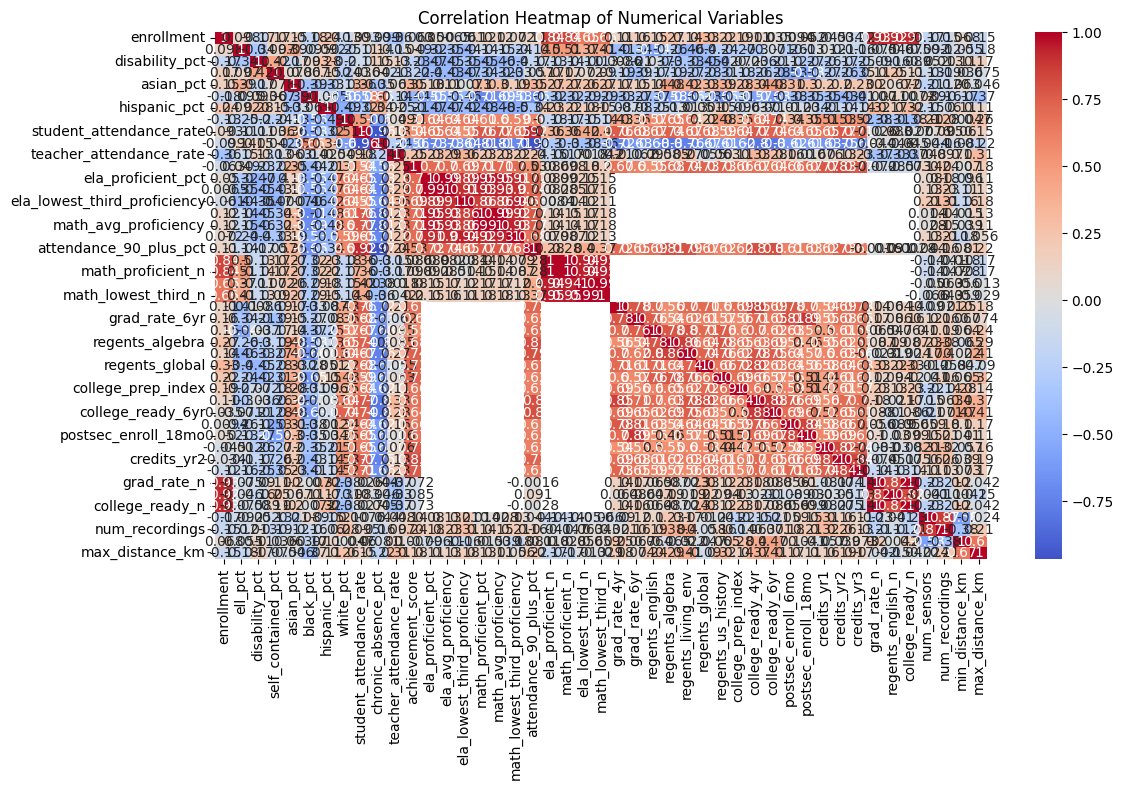

In [24]:
# Get numerical columns, excluding sensor columns
num_cols = final_df.select_dtypes(include=['int64', 'float64']).columns
exclude_cols = ['DBN'] + [col for col in final_df.columns if 'sensor_' in col]  # exclude DBN and sensor columns
num_cols = [col for col in num_cols if col not in exclude_cols]

print("Analyzing these numerical columns:")
print(num_cols)  # removed .tolist() since num_cols is already a list

# Create figure for distributions
n_cols = len(num_cols)
fig_rows = (n_cols + 1) // 2  # 2 plots per row
fig, axes = plt.subplots(fig_rows, 2, figsize=(15, 5*fig_rows))
axes = axes.flatten()

# Store analysis results in a dictionary
distribution_info = {}

# Analyze each numerical column
for idx, col in enumerate(num_cols):
    # Basic statistics
    stats = final_df[col].describe()
    
    # Calculate skewness and kurtosis
    skewness = final_df[col].skew()
    kurtosis = final_df[col].kurtosis()
    
    # Plot histogram with KDE
    sns.histplot(data=final_df, x=col, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')
    
    # Add mean and median lines
    axes[idx].axvline(stats['mean'], color='red', linestyle='--', label='Mean')
    axes[idx].axvline(stats['50%'], color='green', linestyle='--', label='Median')
    axes[idx].legend()
    
    # Print analysis
    print(f"\n{'='*50}")
    print(f"Analysis of {col}")
    print(f"{'='*50}")
    print("\nBasic Statistics:")
    print(stats)
    print(f"\nSkewness: {skewness:.2f}")
    print(f"Kurtosis: {kurtosis:.2f}")
    
    # Note any significant characteristics
    if abs(skewness) > 1:
        print("\nNote: Distribution is significantly skewed")
    if kurtosis > 3:
        print("Note: Distribution has heavy tails")
        
    # Check for outliers
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = final_df[(final_df[col] < lower_bound) | (final_df[col] > upper_bound)][col]
    if len(outliers) > 0:
        print(f"\nOutliers detected: {len(outliers)} ({len(outliers)/len(final_df)*100:.1f}%)")
        print(f"Outlier range: {outliers.min():.2f} to {outliers.max():.2f}")

plt.tight_layout()
plt.show()

# Create summary table of key metrics
summary_table = pd.DataFrame({
    'Mean': final_df[num_cols].mean(),
    'Median': final_df[num_cols].median(),
    'Std Dev': final_df[num_cols].std(),
    'Skewness': final_df[num_cols].skew(),
    'Kurtosis': final_df[num_cols].kurtosis(),
    'Missing Values': final_df[num_cols].isnull().sum(),
    'Missing %': (final_df[num_cols].isnull().sum() / len(final_df) * 100).round(2)
})

print("\nSummary Table of Key Metrics:")
print(summary_table)

# Optional: Box plots for another view of distributions and outliers
plt.figure(figsize=(15, 6))
sns.boxplot(data=final_df[num_cols])
plt.xticks(rotation=45)
plt.title('Distribution and Outliers of Numerical Variables')
plt.tight_layout()
plt.show()

# Optional: Correlation heatmap for numerical variables
plt.figure(figsize=(12, 8))
sns.heatmap(final_df[num_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()

In [25]:
final_df['grad_rate_n']

0        NaN
1        NaN
2        NaN
3        NaN
4       88.0
5        NaN
6       88.0
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14      92.0
15       NaN
16      -1.0
17       NaN
18      -1.0
19      -1.0
20       1.0
21      92.0
22       NaN
23     128.0
24       NaN
25     100.0
26       NaN
27      60.0
28       NaN
29      60.0
30       NaN
31     100.0
32       NaN
33     100.0
34     142.0
35     374.0
36      83.0
37       NaN
38     149.0
39     154.0
40      53.0
41      91.0
42      97.0
43     108.0
44       NaN
45      49.0
46     115.0
47      94.0
48     110.0
49       NaN
50      69.0
51       NaN
52      69.0
53     113.0
54     105.0
55       NaN
56      43.0
57       NaN
58       NaN
59       NaN
60       NaN
61      52.0
62     200.0
63       NaN
64     182.0
65       NaN
66       NaN
67       NaN
68       NaN
69       NaN
70       NaN
71       NaN
72       NaN
73      92.0
74       NaN
75      92.0
76       NaN